# Generation of plots for tutorial on good talks

*This document was created from a Jupyter notebook.  You can download the notebook [here](l04_good_plots_for_slides.ipynb).*

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import scipy.stats as st

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Markov chain Monte Carlo package
import emcee

import bokeh.plotting
import bokeh.io
import bokeh.charts
import bokeh.models
bokeh.io.output_notebook()

BokehJS successfully loaded.

## Data set and necessary calculations

The data set consists of reversals of worms from three strains, wild type, Channelrhodopsin in the ASH neuron, and Channelrhodopsin in the AVA neuron.  We got, respectively, 0/35, 9/35, and 33/36 reversals.

In [2]:
# Store data set
r = np.array([0, 9, 33])
n = np.array([35, 35, 36])
strains = ('wild type', 'ASH', 'AVA')

The posterior distribution is

\begin{align}
P(p_\mathrm{rev}) = \frac{(n+1)!}{r!(n-r)!}\,p_\mathrm{rev}^r\,(1-p_\mathrm{rev})^{n-r}.
\end{align}

We can write a function to compute this, since we'll need it for plotting.

In [3]:
def posterior(p_rev, r, n):
    """Log posterior of reversal measurements."""
    return (n + 1) * st.binom.pmf(r, n, p_rev)

Later, we will plot 95% confidence intervals that contain the highest probability density, or HPD.  This is easily computed analytically for the case where $r = 0$, since, in this case,

\begin{align}
P(p_\mathrm{rev}) = (n+1)(1-p_\mathrm{rev})^n
\end{align}

This decreases monotonically with $p_\mathrm{rev}$.  Then, the minimum of the HPD interval is $0$.  We can find the maximum by evaluating

\begin{align}
\int_0^{p_\mathrm{rev}^\mathrm{max}} \mathrm{d}p_\mathrm{rev}\,P(p_\mathrm{rev}) = 
1-(1-p_\mathrm{rev}^\mathrm{max})^{n+1} = f_\mathrm{HPD},
\end{align}

where $f_\mathrm{HPD}$ is the fraction of the total space of values that the HPD covers (in our case, 0.95).  This is solved to give

\begin{align}
p_\mathrm{rev}^\mathrm{max} = 1 - (1-f_\mathrm{HPD})^{(n+1)^{-1}}.
\end{align}

So, we can compute the HPD for the wild type.

In [4]:
# Intialize PDs, filling in WT value
hpds = [(0, 1 - (1 - 0.95)**(1 / (n[0] + 1))), None, None]

We will compute the HPDs using Markov chain Monte Carlo.  First, we need a function for the log posterior.

In [5]:
def log_posterior(p_rev, r, n):
    """Unnormalized log posterior, used for MCMC calculations."""
    # Get scalar probability (emcee expects array argument)
    p = p_rev[0]

    if p < 0 or p > 1:
        return -np.inf
    return r * np.log(p) + (n - r) * np.log(1-p)

Now we'll write a function to set up and run an MCMC calculation.

In [6]:
def sample_posterior_mcmc(r, n, n_walkers=50, n_burn=5000, n_steps=5000):
    """Get samples of p_rev from the posterior."""

    # Specify starting points of walkers
    p0 = np.empty((n_walkers, 1))
    p0[:,0] = np.random.uniform(0, 1, n_walkers)

    # Instantiate sampler
    sampler = emcee.EnsembleSampler(n_walkers, 1, log_posterior, args=(r, n))
    
    # Do burn-in and sampling
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler

Next, we need a function to compute the HPD from the samples.

In [7]:
def hpd(sampler, mass_frac):
    """
    Returns highest probability density region given by
    a set of samples.
    """
    trace = sampler.flatchain
    
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)
    
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    
    # Return interval
    return np.sort(np.array([d[min_int], d[min_int+n_samples]]).flatten())

We will compute the mode and HPD for the ASH and AVA strains.

In [8]:
for i in (1, 2):
    sampler = sample_posterior_mcmc(r[i], n[i])
    hpds[i] = hpd(sampler, 0.95)

Now that all of our calculations are done, we can make our plots.

## Ugly plots

We'll begin by making the "ugly" plots that are more or less defaults, but not really useful for presentations.  We'll start with a bar chart.

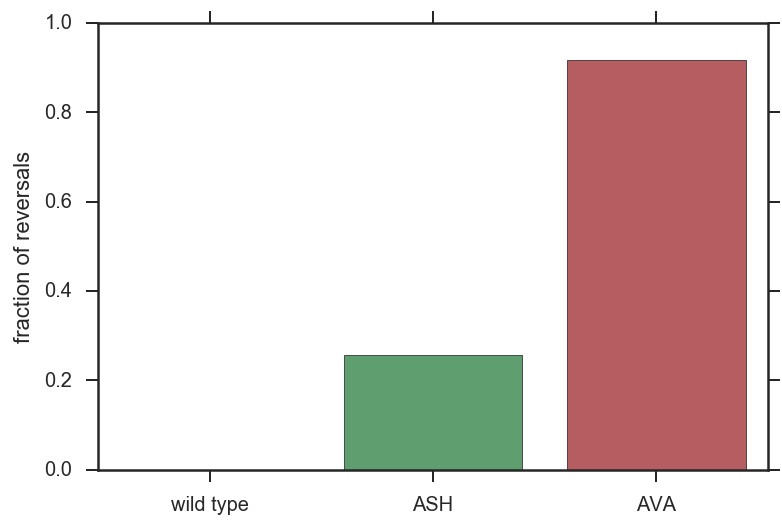

In [9]:
# Make a bad bar plot using Seaborn with its defaults
sns.set_style('ticks')
sns.barplot(x=strains, y=r/n)
plt.ylabel('fraction of reversals')

Now we'll use Bokeh to make an ugly plot of the posterior probabilities.

In [10]:
# p_rev for plotting
p_rev = np.linspace(0, 1, 300)

# Make plots
p = bokeh.plotting.figure(plot_width=650, plot_height=450)
p.xaxis.axis_label = 'reversal probability'
p.yaxis.axis_label = 'probability'

colors = ['blue', 'green', 'red']
line_style = ['solid', 'dashed', 'dotted']

for i, r_val in enumerate(r):
    n_val = n[i]
    p.line(p_rev, posterior(p_rev, r_val, n_val), line_width=4, 
           color=colors[i], line_dash=line_style[i], legend=strains[i])

bokeh.io.show(p)

## Pretty plots

Now, we'll use Bokeh to make pretty plots for our presentation.  We will not label the axes, since we will label these on the slide with well-placed horizontal text.  We also do not annotate, beyond tick labels.

Note that I use the font Concourse T3 for the tick labels.  This font is a font I bought and installed on my system.  You will not have it (unless you bought it), so you will have to change that font selection to make the following code work.

We'll start by specifying the colors for our bars and curves.

In [11]:
colors_bar = ('gray', '#a6cee3', '#fdbf6f')
colors_plot = ('gray', '#1f78b4', '#ff7f00')

We'll start with our horizontal bar chart.  We use Bokeh's `quad()` function to get the bars.

In [12]:
# Set up canvas on which to paint plot
p = bokeh.plotting.figure(plot_width=550, plot_height=290, x_range=[0, 1],
                          y_range=[0.5, 3.25], 
                          border_fill_alpha=0, background_fill_alpha=0, )
p.axis.major_tick_in = 0
p.axis.minor_tick_line_color = None
p.axis.major_label_text_font = 'Concourse T3'
p.grid.grid_line_color = None
p.axis.axis_line_color = '#a6aaa9'
p.axis.major_tick_line_color = '#a6aaa9'
p.axis.major_label_text_color = '#53585f'
p.axis.axis_line_width = 2
p.axis.major_tick_line_width = 2
p.yaxis.visible = None
p.outline_line_alpha = 0
p.xaxis[0].ticker = bokeh.models.FixedTicker(ticks=[0, 1])

# Grid lines
for i in range(1, 4):
    p.line([0, 1], [i]*2, color='#A6AAA9', line_width=2)

# Populate bars
for i in range(3):
    p.quad(0, r[i]/n[i], 3-i+0.25, 3-i-0.25, color=colors_bar[i])

bokeh.io.show(p)

Next, we'll make a plot of the posterior probabilities.

In [13]:
# Values of p for plot
p_rev = np.linspace(0, 1, 300)

# Set up plot
p = bokeh.plotting.figure(plot_width=650, plot_height=450, x_range=[-0.01,1.01],
                          border_fill_alpha=0, background_fill_alpha=0, )
p.axis.major_tick_in = 0
p.axis.minor_tick_line_color = None
p.axis.major_label_text_font = 'Concourse T3'
p.grid.grid_line_color = None
p.axis.axis_line_color = '#a6aaa9'
p.axis.major_tick_line_color = '#a6aaa9'
p.axis.major_label_text_color = '#53585f'
p.axis.axis_line_width = 2
p.axis.major_tick_line_width = 2
p.outline_line_alpha = 0

# Populate glyphs
for i, r_val in enumerate(r):
    n_val = n[i]
    p.line(p_rev, posterior(p_rev, r_val, n_val), line_width=4, 
           color=colors_plot[i])

bokeh.io.show(p)

Finally, we will make a plot of the confidence intervals.

In [14]:
# Set up plot
p = bokeh.plotting.figure(plot_width=550, plot_height=290, x_range=[-0.02,1.02],
                          y_range=[0.7, 3.3], 
                          border_fill_alpha=0, background_fill_alpha=0, )
p.axis.major_tick_in = 0
p.axis.minor_tick_line_color = None
p.axis.major_label_text_font = 'Concourse T3'
p.grid.grid_line_color = None
p.axis.axis_line_color = '#a6aaa9'
p.axis.major_tick_line_color = '#a6aaa9'
p.axis.major_label_text_color = '#53585f'
p.axis.axis_line_width = 2
p.axis.major_tick_line_width = 2
p.yaxis.visible = None
p.outline_line_alpha = 0

# Grid lines
for i in range(1, 4):
    p.line([0, 1], [i]*2, color='#A6AAA9', line_width=2)

# Plot data
for i in range(3):
    p.circle(r[i]/n[i], 3-i, color=colors_plot[i], size=10)
    p.line(hpds[i], [3-i]*2, color=colors_plot[i], line_width=6, line_cap='round')

bokeh.io.show(p)